In [1]:
from utils.binaries import *
from utils.plotting import *

from scipy.optimize import curve_fit
from scipy.stats import landau
from scipy.special import expit
from scipy.integrate import quad


13:42:22 (  +12.7s) [INFO   ] -- import logging
13:42:22 (   +91ms) [INFO   ] -- import numpy as np
13:42:22 (    +6ms) [INFO   ] -- import uncertainties
13:42:22 (  +255ms) [INFO   ] -- import pandas as pd
13:42:22 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:42:22 (    +1ms) [INFO   ] -- import binaries.tools as tools
13:42:23 (  +303ms) [INFO   ] -- import matplotlib.pyplot as plt
13:42:23 (  +499ms) [INFO   ] -- import seaborn as so
13:42:23 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:42:23 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:42:23 (    +0ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
13:42:23 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
13:42:23 (    +0ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
13:42:23 (    +0ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offline/in

Text(0.5, 0, '$I^\\mathrm{SSD}_\\mathrm{histo}$')

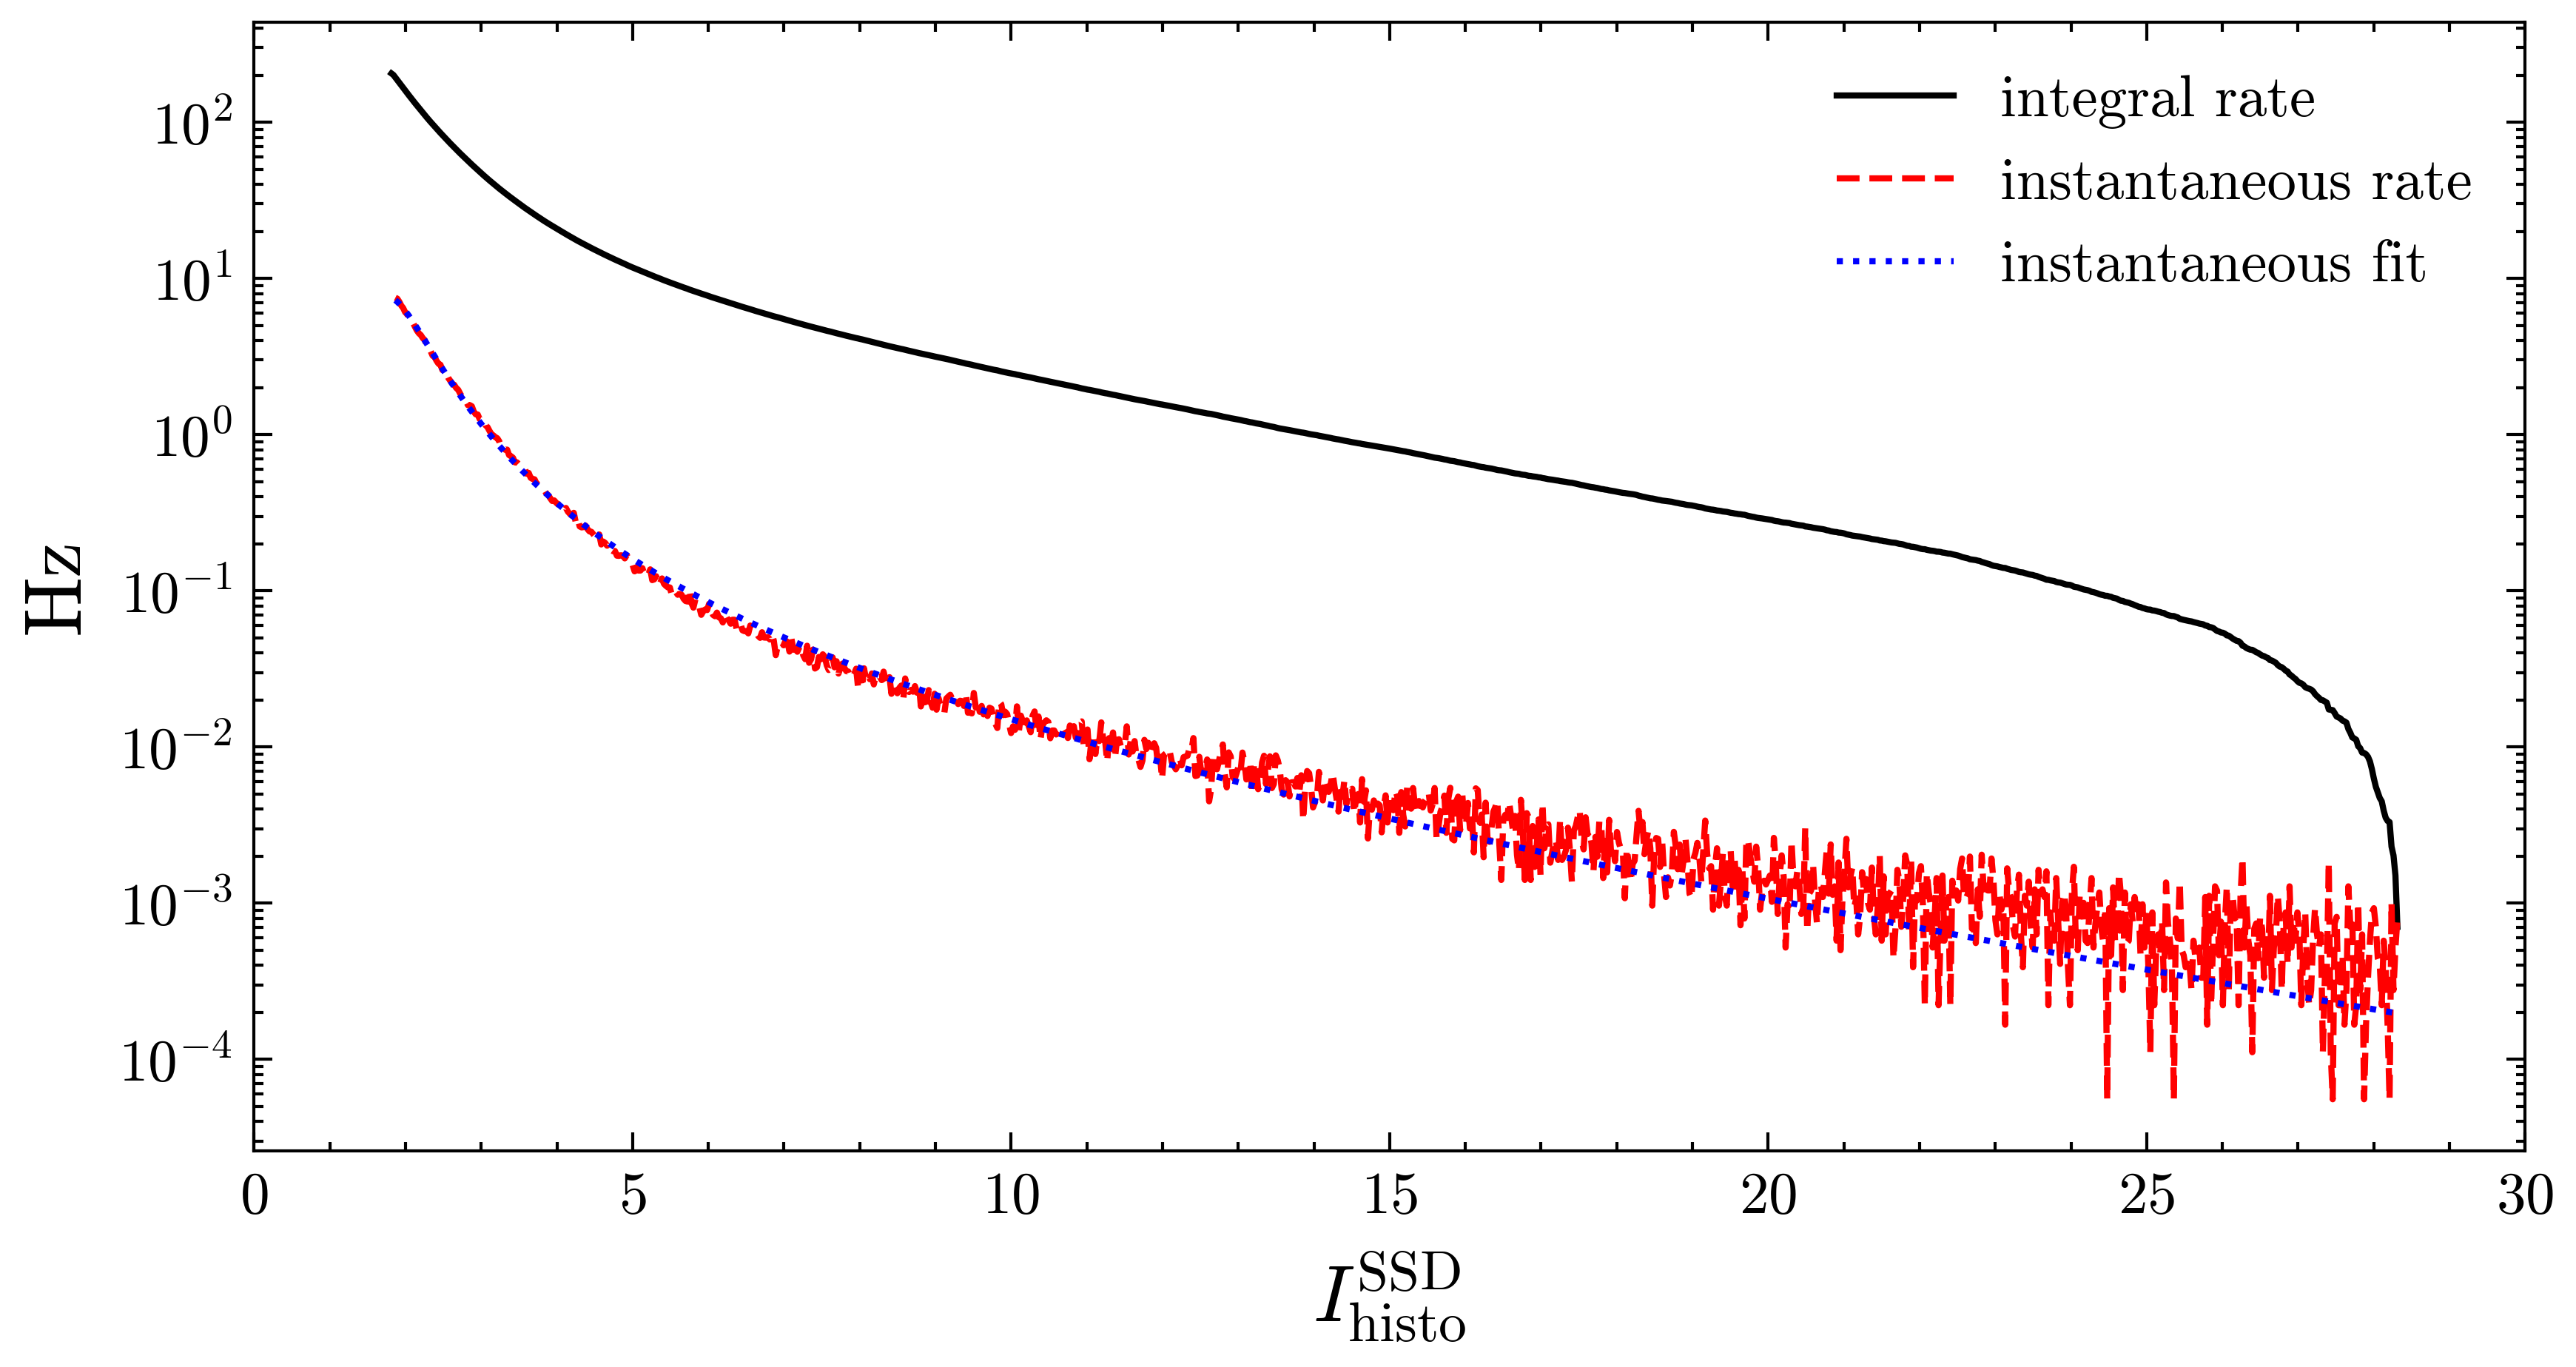

In [2]:
x, y = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
inst_y = -np.diff(y[1:])

def llandau(x, norm, loc, scale, suppression, cutoff):
    return norm * landau(loc, scale).pdf(x) * (1 - expit((x-cutoff)*suppression))

popt, pcov = curve_fit(llandau, x[2:], inst_y,
                       bounds=([0, 0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf, np.inf]),
                       p0=[31.88461781, 1.71248985, 0.34490904, 0., 0],
                       sigma=np.sqrt(inst_y/60))

int_fit = lambda x: [quad(lambda y: llandau(y, *popt), xs, np.inf)[0] for xs in x]

plt.plot(x, y, label='integral rate')
plt.plot(x[2:], inst_y, label='instantaneous rate', marker='none')
plt.plot(x[2:], llandau(x[2:], *popt), label='instantaneous fit', marker='none')
# plt.plot(x[2:], int_fit(x[2:]), label='fit integral', marker='none')

plt.legend()
plt.xlim(0, 30)
plt.ylabel("Hz")
plt.yscale('log')
plt.xlabel("$I^\mathrm{SSD}_\mathrm{histo}$")

In [3]:
# from data

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 5

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

after t_cal = np.int64(60) s, rate was 71.42 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 68.53 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 73.59 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 69.16 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.52 Hz and threshold will be 2.66 (= 0.01)


In [ ]:
# from fit

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 5

popt_wo_supression = [6.23582273e+00, 2.03615735e+00, 2.71378320e-01, 0.00000000e-01, 0.00000000e-01]
popt_w_suppression = [1.87140748e+01, 1.90879654e+00, 3.13438255e-01, 1.17255626e-01, 4.87078402e-15]

f_with = lambda x: llandau(x, *popt_w_suppression)
f_without = lambda x: llandau(x, *popt_wo_supression)

while t_cal <= 60 or n_repeat:
    
    # calculate trigger rate
    integral_rate_above, _ = quad(f_without, t_70, np.inf)
    n_above = np.random.poisson(integral_rate_above * t_cal)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
    print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

after t_cal = np.int64(10) s, rate was 2.60 Hz and threshold will be 1.00 (= -0.62)
after t_cal = np.int64(10) s, rate was 2.90 Hz and threshold will be 0.98 (= -0.63)
after t_cal = np.int64(10) s, rate was 4.40 Hz and threshold will be 0.96 (= -0.64)
after t_cal = np.int64(10) s, rate was 3.50 Hz and threshold will be 0.94 (= -0.64)
after t_cal = np.int64(10) s, rate was 2.90 Hz and threshold will be 0.92 (= -0.65)
after t_cal = np.int64(10) s, rate was 2.80 Hz and threshold will be 0.90 (= -0.66)
after t_cal = np.int64(10) s, rate was 3.60 Hz and threshold will be 0.88 (= -0.67)
after t_cal = np.int64(10) s, rate was 2.70 Hz and threshold will be 0.86 (= -0.67)
after t_cal = np.int64(10) s, rate was 3.30 Hz and threshold will be 0.84 (= -0.68)
after t_cal = np.int64(10) s, rate was 2.40 Hz and threshold will be 0.82 (= -0.69)
after t_cal = np.int64(10) s, rate was 2.60 Hz and threshold will be 0.80 (= -0.70)
after t_cal = np.int64(10) s, rate was 3.00 Hz and threshold will be 0.78 (=

KeyboardInterrupt: 